# SaaS Churn Prediction Model

## Mục tiêu
Xây dựng mô hình Machine Learning để dự báo khách hàng sẽ churn hay không dựa trên:
- Thông tin account (industry, country, plan_tier, etc.)
- Lịch sử subscription (MRR, seats, upgrades/downgrades)
- Sử dụng features (adoption rate, error rate)
- Support tickets (priority, resolution time, satisfaction)

## Model Pipeline
1. **Data Preprocessing**: Merge tables, feature engineering
2. **Feature Selection**: Xác định features quan trọng nhất
3. **Model Training**: Thử nhiều algorithms (Logistic Regression, Random Forest, XGBoost)
4. **Model Evaluation**: Accuracy, Precision, Recall, F1, AUC-ROC
5. **Feature Importance**: Phân tích các factors ảnh hưởng churn
6. **Predictions**: Dự báo churn probability cho từng customer

## 1. Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)

# Cấu hình
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load dataset
import kagglehub
dataset_path = kagglehub.dataset_download("rivalytics/saas-subscription-and-churn-analytics-dataset")

accounts = pd.read_csv(os.path.join(dataset_path, 'ravenstack_accounts.csv'))
subscriptions = pd.read_csv(os.path.join(dataset_path, 'ravenstack_subscriptions.csv'))
feature_usage = pd.read_csv(os.path.join(dataset_path, 'ravenstack_feature_usage.csv'))
support_tickets = pd.read_csv(os.path.join(dataset_path, 'ravenstack_support_tickets.csv'))
churn_events = pd.read_csv(os.path.join(dataset_path, 'ravenstack_churn_events.csv'))

print("✓ Dữ liệu đã được load thành công")
print(f"  Accounts: {accounts.shape}")
print(f"  Subscriptions: {subscriptions.shape}")
print(f"  Feature Usage: {feature_usage.shape}")
print(f"  Support Tickets: {support_tickets.shape}")
print(f"  Churn Events: {churn_events.shape}")

100%|██████████| 586k/586k [00:00<00:00, 83.6MB/s]

Extracting files...
✓ Dữ liệu đã được load thành công
  Accounts: (500, 10)
  Subscriptions: (5000, 14)
  Feature Usage: (25000, 8)
  Support Tickets: (2000, 9)
  Churn Events: (600, 9)


## 2. Feature Engineering - Tạo Features từ Multiple Tables

In [2]:
# Target Variable: Churn Flag từ Accounts
X_base = accounts[['account_id', 'industry', 'country', 'signup_date',
                    'referral_source', 'plan_tier', 'seats', 'is_trial']].copy()
y = accounts['churn_flag'].astype(int)

print(f"Target variable distribution:")
print(y.value_counts())
print(f"Churn rate: {y.mean()*100:.2f}%\n")

# ===== SUBSCRIPTION FEATURES =====
# Group by account_id để lấy subscription-level features
sub_features = subscriptions.groupby('account_id').agg({
    'subscription_id': 'count',           # num_subscriptions
    'mrr_amount': ['sum', 'mean', 'max'], # total/avg/max MRR
    'arr_amount': ['sum', 'mean'],        # total/avg ARR
    'seats': ['sum', 'mean'],             # total/avg seats
    'upgrade_flag': 'sum',                # num_upgrades
    'downgrade_flag': 'sum',              # num_downgrades
    'churn_flag': 'sum',                  # num_churned_subs
    'auto_renew_flag': 'mean'             # auto_renew_pct
}).reset_index()

# Flatten column names
sub_features.columns = ['account_id', 'num_subscriptions', 'total_mrr', 'avg_mrr', 'max_mrr',
                        'total_arr', 'avg_arr', 'total_seats', 'avg_seats',
                        'num_upgrades', 'num_downgrades', 'num_churned_subs', 'auto_renew_pct']

print("Subscription Features:")
print(sub_features.head())
print(f"Shape: {sub_features.shape}\n")

# ===== FEATURE USAGE FEATURES =====
# Per subscription
usage_per_sub = feature_usage.groupby('subscription_id').agg({
    'usage_id': 'count',                  # total_usage_events
    'usage_count': 'sum',                 # total_usage_count
    'usage_duration_secs': ['sum', 'mean'], # total/avg duration
    'error_count': ['sum', 'mean'],       # total/avg errors
    'is_beta_feature': 'mean'             # beta_feature_usage_pct
}).reset_index()

usage_per_sub.columns = ['subscription_id', 'total_usage_events', 'total_usage_count',
                          'total_usage_duration', 'avg_usage_duration',
                          'total_usage_errors', 'avg_usage_errors', 'beta_feature_pct']

# Merge dengan subscriptions untuk get account_id
usage_per_sub = usage_per_sub.merge(subscriptions[['subscription_id', 'account_id']],
                                     on='subscription_id', how='left')

# Aggregate by account_id
usage_features = usage_per_sub.groupby('account_id').agg({
    'total_usage_events': ['sum', 'mean'],
    'total_usage_count': ['sum', 'mean'],
    'total_usage_duration': ['sum', 'mean'],
    'avg_usage_errors': 'mean',
    'beta_feature_pct': 'mean'
}).reset_index()

usage_features.columns = ['account_id', 'total_usage_events', 'avg_usage_events_per_sub',
                          'total_usage_count', 'avg_usage_count_per_sub',
                          'total_usage_duration', 'avg_usage_duration',
                          'avg_error_rate', 'beta_feature_engagement']

print("Feature Usage Features:")
print(usage_features.head())
print(f"Shape: {usage_features.shape}\n")

# ===== SUPPORT TICKETS FEATURES =====
support_features = support_tickets.groupby('account_id').agg({
    'ticket_id': 'count',                      # num_tickets
    'priority': lambda x: (x == 'urgent').sum(), # urgent_tickets_count
    'resolution_time_hours': ['mean', 'max'],   # avg/max resolution time
    'first_response_time_minutes': 'mean',      # avg first response time
    'satisfaction_score': 'mean',               # avg satisfaction
    'escalation_flag': 'mean'                   # escalation_rate
}).reset_index()

support_features.columns = ['account_id', 'num_support_tickets', 'urgent_tickets_count',
                            'avg_resolution_time', 'max_resolution_time',
                            'avg_first_response_time', 'avg_satisfaction_score',
                            'escalation_rate']

print("Support Tickets Features:")
print(support_features.head())
print(f"Shape: {support_features.shape}\n")

# ===== CHURN EVENT FEATURES =====
# Check if account has previous churn events and refunds
churn_features = churn_events.groupby('account_id').agg({
    'churn_event_id': 'count',          # num_churn_events
    'refund_amount_usd': ['sum', 'mean'], # total/avg refund
    'preceding_upgrade_flag': 'sum',    # upgrades_before_churn
    'preceding_downgrade_flag': 'sum',  # downgrades_before_churn
    'is_reactivation': 'sum'            # reactivation_count
}).reset_index()

churn_features.columns = ['account_id', 'num_churn_events', 'total_refunds', 'avg_refund',
                          'upgrades_before_churn', 'downgrades_before_churn', 'reactivation_count']

print("Churn Event Features:")
print(churn_features.head())
print(f"Shape: {churn_features.shape}")

Target variable distribution:
churn_flag
0    390
1    110
Name: count, dtype: int64
Churn rate: 22.00%

Subscription Features:
  account_id  num_subscriptions  total_mrr      avg_mrr  max_mrr  total_arr  \
0   A-00bed1                 10      33506  3350.600000     9751     402072   
1   A-00cac8                  9      14121  1569.000000     7761     169452   
2   A-0158bb                  6       4070   678.333333     2205      48840   
3   A-016043                 11      16516  1501.454545     4776     198192   
4   A-019782                  9       8353   928.111111     3184     100236   

        avg_arr  total_seats  avg_seats  num_upgrades  num_downgrades  \
0  40207.200000          342  34.200000             3               0   
1  18828.000000          138  15.333333             0               1   
2   8140.000000          155  25.833333             1               0   
3  18017.454545          225  20.454545             3               0   
4  11137.333333          123  13

In [3]:
# ===== MERGE ALL FEATURES =====
X_merged = X_base.merge(sub_features, on='account_id', how='left')
X_merged = X_merged.merge(usage_features, on='account_id', how='left')
X_merged = X_merged.merge(support_features, on='account_id', how='left')
X_merged = X_merged.merge(churn_features, on='account_id', how='left')

print("Combined Features DataFrame:")
print(X_merged.head())
print(f"\nShape: {X_merged.shape}")
print(f"\nColumns: {list(X_merged.columns)}\n")

# Handle missing values - fill with 0 (no activity)
X_merged = X_merged.fillna(0)

print("Missing values after fill:")
print(X_merged.isnull().sum().sum())
print(f"\nFinal dataset shape: {X_merged.shape}")

Combined Features DataFrame:
  account_id    industry country signup_date referral_source   plan_tier  \
0   A-2e4581      EdTech      US  2024-10-16         partner       Basic   
1   A-43a9e3     FinTech      IN  2023-08-17           other       Basic   
2   A-0a282f    DevTools      US  2024-08-27         organic       Basic   
3   A-1f0ac7  HealthTech      UK  2023-08-27           other       Basic   
4   A-ce550d  HealthTech      US  2024-10-27           event  Enterprise   

   seats  is_trial  num_subscriptions  total_mrr      avg_mrr  max_mrr  \
0      9     False                 10      12603  1260.300000     5771   
1     18     False                  8      10004  1250.500000     5572   
2      1     False                 15      18286  1219.066667     5771   
3     24      True                  7       9275  1325.000000     4776   
4     35     False                  9      48761  5417.888889    21691   

   total_arr       avg_arr  total_seats  avg_seats  num_upgrades  \
0

## 3. Data Preprocessing & Feature Encoding

In [4]:
X_processed = X_merged.copy()

# Drop account_id (not a feature)
X_processed = X_processed.drop('account_id', axis=1)

# Convert signup_date to days since signup
X_processed['signup_date'] = pd.to_datetime(X_processed['signup_date'])
X_processed['days_since_signup'] = (pd.Timestamp.now() - X_processed['signup_date']).dt.days
X_processed = X_processed.drop('signup_date', axis=1)

print("Date feature created:")
print(f"Days since signup range: {X_processed['days_since_signup'].min()} to {X_processed['days_since_signup'].max()}\n")

# Encode categorical variables
print("Categorical columns to encode:")
categorical_cols = ['industry', 'country', 'referral_source', 'plan_tier', 'is_trial']
print(categorical_cols)

# Use Label Encoding for tree-based models compatibility
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} classes")

print(f"\nProcessed features shape: {X_processed.shape}")
print(f"Features: {list(X_processed.columns)}\n")

# Check for any remaining missing values
print("Final missing values check:")
print(X_processed.isnull().sum())
print(f"\n✓ Data preprocessing complete")

Date feature created:
Days since signup range: 340 to 1069

Categorical columns to encode:
['industry', 'country', 'referral_source', 'plan_tier', 'is_trial']
  industry: 5 classes
  country: 7 classes
  referral_source: 5 classes
  plan_tier: 3 classes
  is_trial: 2 classes

Processed features shape: (500, 40)
Features: ['industry', 'country', 'referral_source', 'plan_tier', 'seats', 'is_trial', 'num_subscriptions', 'total_mrr', 'avg_mrr', 'max_mrr', 'total_arr', 'avg_arr', 'total_seats', 'avg_seats', 'num_upgrades', 'num_downgrades', 'num_churned_subs', 'auto_renew_pct', 'total_usage_events', 'avg_usage_events_per_sub', 'total_usage_count', 'avg_usage_count_per_sub', 'total_usage_duration', 'avg_usage_duration', 'avg_error_rate', 'beta_feature_engagement', 'num_support_tickets', 'urgent_tickets_count', 'avg_resolution_time', 'max_resolution_time', 'avg_first_response_time', 'avg_satisfaction_score', 'escalation_rate', 'num_churn_events', 'total_refunds', 'avg_refund', 'upgrades_befor

## 4. Train-Test Split & Model Training

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training:")
print(y_train.value_counts())
print(f"\nClass distribution in test:")
print(y_test.value_counts())

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data split and scaled successfully")

Training set: (400, 40)
Test set: (100, 40)

Class distribution in training:
churn_flag
0    312
1     88
Name: count, dtype: int64

Class distribution in test:
churn_flag
0    78
1    22
Name: count, dtype: int64

✓ Data split and scaled successfully


In [6]:
# Dictionary để lưu models
models = {}
results = {}

print("=" * 80)
print("MODEL TRAINING - Thử 3 algorithms khác nhau")
print("=" * 80)

# ===== MODEL 1: LOGISTIC REGRESSION =====
print("\n1️⃣ LOGISTIC REGRESSION")
print("-" * 80)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'auc_roc': roc_auc_score(y_test, y_pred_prob_lr),
    'y_pred': y_pred_lr,
    'y_pred_prob': y_pred_prob_lr
}

print(f"Accuracy:  {results['Logistic Regression']['accuracy']:.4f}")
print(f"Precision: {results['Logistic Regression']['precision']:.4f}")
print(f"Recall:    {results['Logistic Regression']['recall']:.4f}")
print(f"F1 Score:  {results['Logistic Regression']['f1']:.4f}")
print(f"AUC-ROC:   {results['Logistic Regression']['auc_roc']:.4f}")

# ===== MODEL 2: RANDOM FOREST =====
print("\n2️⃣ RANDOM FOREST CLASSIFIER")
print("-" * 80)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'auc_roc': roc_auc_score(y_test, y_pred_prob_rf),
    'y_pred': y_pred_rf,
    'y_pred_prob': y_pred_prob_rf
}

print(f"Accuracy:  {results['Random Forest']['accuracy']:.4f}")
print(f"Precision: {results['Random Forest']['precision']:.4f}")
print(f"Recall:    {results['Random Forest']['recall']:.4f}")
print(f"F1 Score:  {results['Random Forest']['f1']:.4f}")
print(f"AUC-ROC:   {results['Random Forest']['auc_roc']:.4f}")

# ===== MODEL 3: GRADIENT BOOSTING =====
print("\n3️⃣ GRADIENT BOOSTING CLASSIFIER")
print("-" * 80)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model

y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

results['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'auc_roc': roc_auc_score(y_test, y_pred_prob_gb),
    'y_pred': y_pred_gb,
    'y_pred_prob': y_pred_prob_gb
}

print(f"Accuracy:  {results['Gradient Boosting']['accuracy']:.4f}")
print(f"Precision: {results['Gradient Boosting']['precision']:.4f}")
print(f"Recall:    {results['Gradient Boosting']['recall']:.4f}")
print(f"F1 Score:  {results['Gradient Boosting']['f1']:.4f}")
print(f"AUC-ROC:   {results['Gradient Boosting']['auc_roc']:.4f}")

MODEL TRAINING - Thử 3 algorithms khác nhau

1️⃣ LOGISTIC REGRESSION
--------------------------------------------------------------------------------
Accuracy:  0.7800
Precision: 0.5000
Recall:    0.0455
F1 Score:  0.0833
AUC-ROC:   0.5711

2️⃣ RANDOM FOREST CLASSIFIER
--------------------------------------------------------------------------------
Accuracy:  0.7800
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
AUC-ROC:   0.5478

3️⃣ GRADIENT BOOSTING CLASSIFIER
--------------------------------------------------------------------------------
Accuracy:  0.7800
Precision: 0.5000
Recall:    0.0909
F1 Score:  0.1538
AUC-ROC:   0.4913


## 5. Model Comparison & Evaluation


MODEL COMPARISON SUMMARY
                    accuracy precision    recall        f1   auc_roc
Logistic Regression     0.78       0.5  0.045455  0.083333  0.571096
Random Forest           0.78       0.0       0.0       0.0  0.547786
Gradient Boosting       0.78       0.5  0.090909  0.153846  0.491259

🏆 Best Model (by AUC-ROC): Logistic Regression
   AUC-ROC: 0.5711


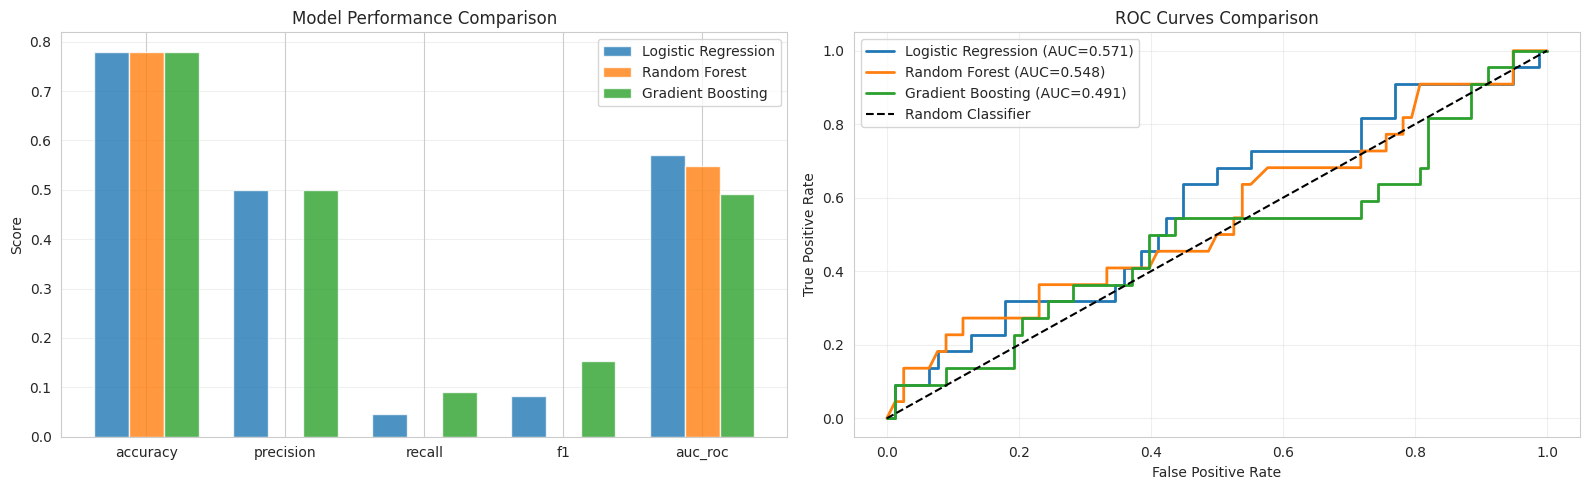

In [7]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']])

# Find best model
best_model_name = comparison_df['auc_roc'].idxmax()
print(f"\n🏆 Best Model (by AUC-ROC): {best_model_name}")
print(f"   AUC-ROC: {comparison_df.loc[best_model_name, 'auc_roc']:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
x_pos = np.arange(len(metrics))
width = 0.25

for i, (model_name, row) in enumerate(comparison_df.iterrows()):
    axes[0].bar(x_pos + i*width, [row[m] for m in metrics],
                width, label=model_name, alpha=0.8)

axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# AUC-ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, results['Logistic Regression']['y_pred_prob'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, results['Random Forest']['y_pred_prob'])
fpr_gb, tpr_gb, _ = roc_curve(y_test, results['Gradient Boosting']['y_pred_prob'])

axes[1].plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={results['Logistic Regression']['auc_roc']:.3f})", lw=2)
axes[1].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={results['Random Forest']['auc_roc']:.3f})", lw=2)
axes[1].plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC={results['Gradient Boosting']['auc_roc']:.3f})", lw=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Confusion matrices
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for model_name in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:
    print(f"\n{model_name.upper()}")
    print("-" * 80)
    print(classification_report(y_test, results[model_name]['y_pred'],
                                target_names=['No Churn', 'Churn']))

    cm = confusion_matrix(y_test, results[model_name]['y_pred'])
    print(f"Confusion Matrix:")
    print(f"  True Negatives: {cm[0, 0]} | False Positives: {cm[0, 1]}")
    print(f"  False Negatives: {cm[1, 0]} | True Positives: {cm[1, 1]}")


DETAILED CLASSIFICATION REPORTS

LOGISTIC REGRESSION
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.79      0.99      0.88        78
       Churn       0.50      0.05      0.08        22

    accuracy                           0.78       100
   macro avg       0.64      0.52      0.48       100
weighted avg       0.72      0.78      0.70       100

Confusion Matrix:
  True Negatives: 77 | False Positives: 1
  False Negatives: 21 | True Positives: 1

RANDOM FOREST
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.78      1.00      0.88        78
       Churn       0.00      0.00      0.00        22

    accuracy                           0.78       100
   macro avg       0.39      0.50      0.44       100
weighted avg       0.61      0.78      0.68       100

Confusion Mat

## 6. Feature Importance Analysis


FEATURE IMPORTANCE (Random Forest - Top 15)
                feature  importance
         avg_error_rate    0.051322
                avg_arr    0.043006
avg_first_response_time    0.041178
      days_since_signup    0.040286
     avg_usage_duration    0.040076
beta_feature_engagement    0.039995
                avg_mrr    0.039296
              avg_seats    0.037700
                max_mrr    0.037098
    avg_resolution_time    0.035687
avg_usage_count_per_sub    0.035202
              total_arr    0.034348
            total_seats    0.033421
   total_usage_duration    0.033156
    max_resolution_time    0.032922

FEATURE IMPORTANCE (Gradient Boosting - Top 15)
                 feature  importance
          avg_error_rate    0.105871
 avg_first_response_time    0.070061
     avg_resolution_time    0.068613
      avg_usage_duration    0.053983
       total_usage_count    0.048242
 beta_feature_engagement    0.047998
             total_seats    0.047137
       days_since_signup    0.0433

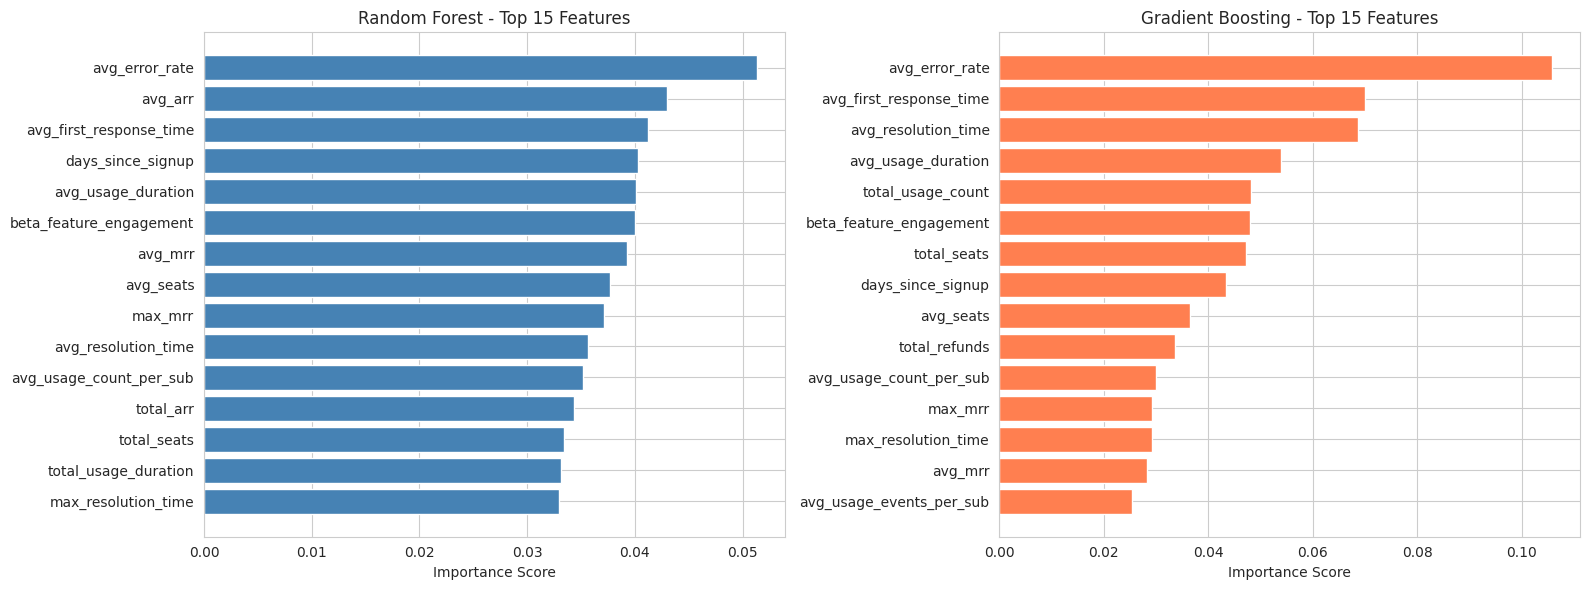


✓ Feature importance analysis complete


In [9]:
# Feature importance from Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE (Random Forest - Top 15)")
print("=" * 80)
print(rf_feature_importance.head(15).to_string(index=False))

# Feature importance from Gradient Boosting
gb_feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE (Gradient Boosting - Top 15)")
print("=" * 80)
print(gb_feature_importance.head(15).to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Top 15
top_n = 15
rf_top = rf_feature_importance.head(top_n)
axes[0].barh(range(len(rf_top)), rf_top['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(rf_top)))
axes[0].set_yticklabels(rf_top['feature'].values)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest - Top 15 Features')
axes[0].invert_yaxis()

# Gradient Boosting Top 15
gb_top = gb_feature_importance.head(top_n)
axes[1].barh(range(len(gb_top)), gb_top['importance'].values, color='coral')
axes[1].set_yticks(range(len(gb_top)))
axes[1].set_yticklabels(gb_top['feature'].values)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Gradient Boosting - Top 15 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")

## 7. Make Predictions on Full Dataset

In [10]:
# Use the best model for predictions
best_model = models[best_model_name]

# Get churn probability for all customers
X_processed_with_id = X_merged[['account_id']].copy()
X_features_only = X_processed.copy()

# Predict probabilities
if best_model_name == 'Logistic Regression':
    churn_probabilities = best_model.predict_proba(X_train_scaled[:len(X_processed)])[:, 1]
    # Scale all data for prediction
    X_features_scaled = scaler.transform(X_features_only)
    churn_probabilities = best_model.predict_proba(X_features_scaled)[:, 1]
else:
    churn_probabilities = best_model.predict_proba(X_features_only)[:, 1]

# Create results DataFrame
predictions_df = pd.DataFrame({
    'account_id': X_processed_with_id['account_id'].values,
    'actual_churn': y.values,
    'predicted_churn_probability': churn_probabilities
})

# Add account information
predictions_df = predictions_df.merge(
    accounts[['account_id', 'account_name', 'industry', 'plan_tier', 'country']],
    on='account_id', how='left'
)

# Classify as churn risk
predictions_df['predicted_churn'] = (predictions_df['predicted_churn_probability'] > 0.5).astype(int)
predictions_df['churn_risk_level'] = pd.cut(
    predictions_df['predicted_churn_probability'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low', 'Medium', 'High']
)

# Sort by churn probability (highest risk first)
predictions_df_sorted = predictions_df.sort_values('predicted_churn_probability', ascending=False)

print("\n" + "=" * 100)
print("CHURN PREDICTIONS FOR ALL CUSTOMERS")
print("=" * 100)
print(f"\nTotal customers: {len(predictions_df)}")
print(f"Actual churned: {predictions_df['actual_churn'].sum()} ({predictions_df['actual_churn'].mean()*100:.1f}%)")
print(f"Predicted as churn risk: {predictions_df['predicted_churn'].sum()} ({predictions_df['predicted_churn'].mean()*100:.1f}%)")
print(f"\nChurn Risk Distribution:")
print(predictions_df['churn_risk_level'].value_counts().sort_index(ascending=False))

print("\n" + "=" * 100)
print("TOP 20 HIGHEST CHURN RISK CUSTOMERS")
print("=" * 100)
print(predictions_df_sorted.head(20)[['account_id', 'account_name', 'industry', 'plan_tier',
                                       'predicted_churn_probability', 'churn_risk_level',
                                       'actual_churn']].to_string(index=False))

print("\n" + "=" * 100)
print("TOP 20 LOWEST CHURN RISK CUSTOMERS")
print("=" * 100)
print(predictions_df_sorted.tail(20)[['account_id', 'account_name', 'industry', 'plan_tier',
                                       'predicted_churn_probability', 'churn_risk_level',
                                       'actual_churn']].to_string(index=False))


CHURN PREDICTIONS FOR ALL CUSTOMERS

Total customers: 500
Actual churned: 110 (22.0%)
Predicted as churn risk: 5 (1.0%)

Churn Risk Distribution:
churn_risk_level
High        1
Medium     88
Low       411
Name: count, dtype: int64

TOP 20 HIGHEST CHURN RISK CUSTOMERS
account_id account_name      industry  plan_tier  predicted_churn_probability churn_risk_level  actual_churn
  A-b30291  Company_344    HealthTech      Basic                     0.757151             High             1
  A-3ce5b8  Company_256       FinTech      Basic                     0.593024           Medium             1
  A-6dee43  Company_478       FinTech      Basic                     0.551958           Medium             0
  A-d922bf  Company_221    HealthTech      Basic                     0.516268           Medium             1
  A-7f29a7  Company_386 Cybersecurity      Basic                     0.502758           Medium             0
  A-9ee962   Company_59    HealthTech      Basic                     0.499865

## 8. Visualizations & Insights

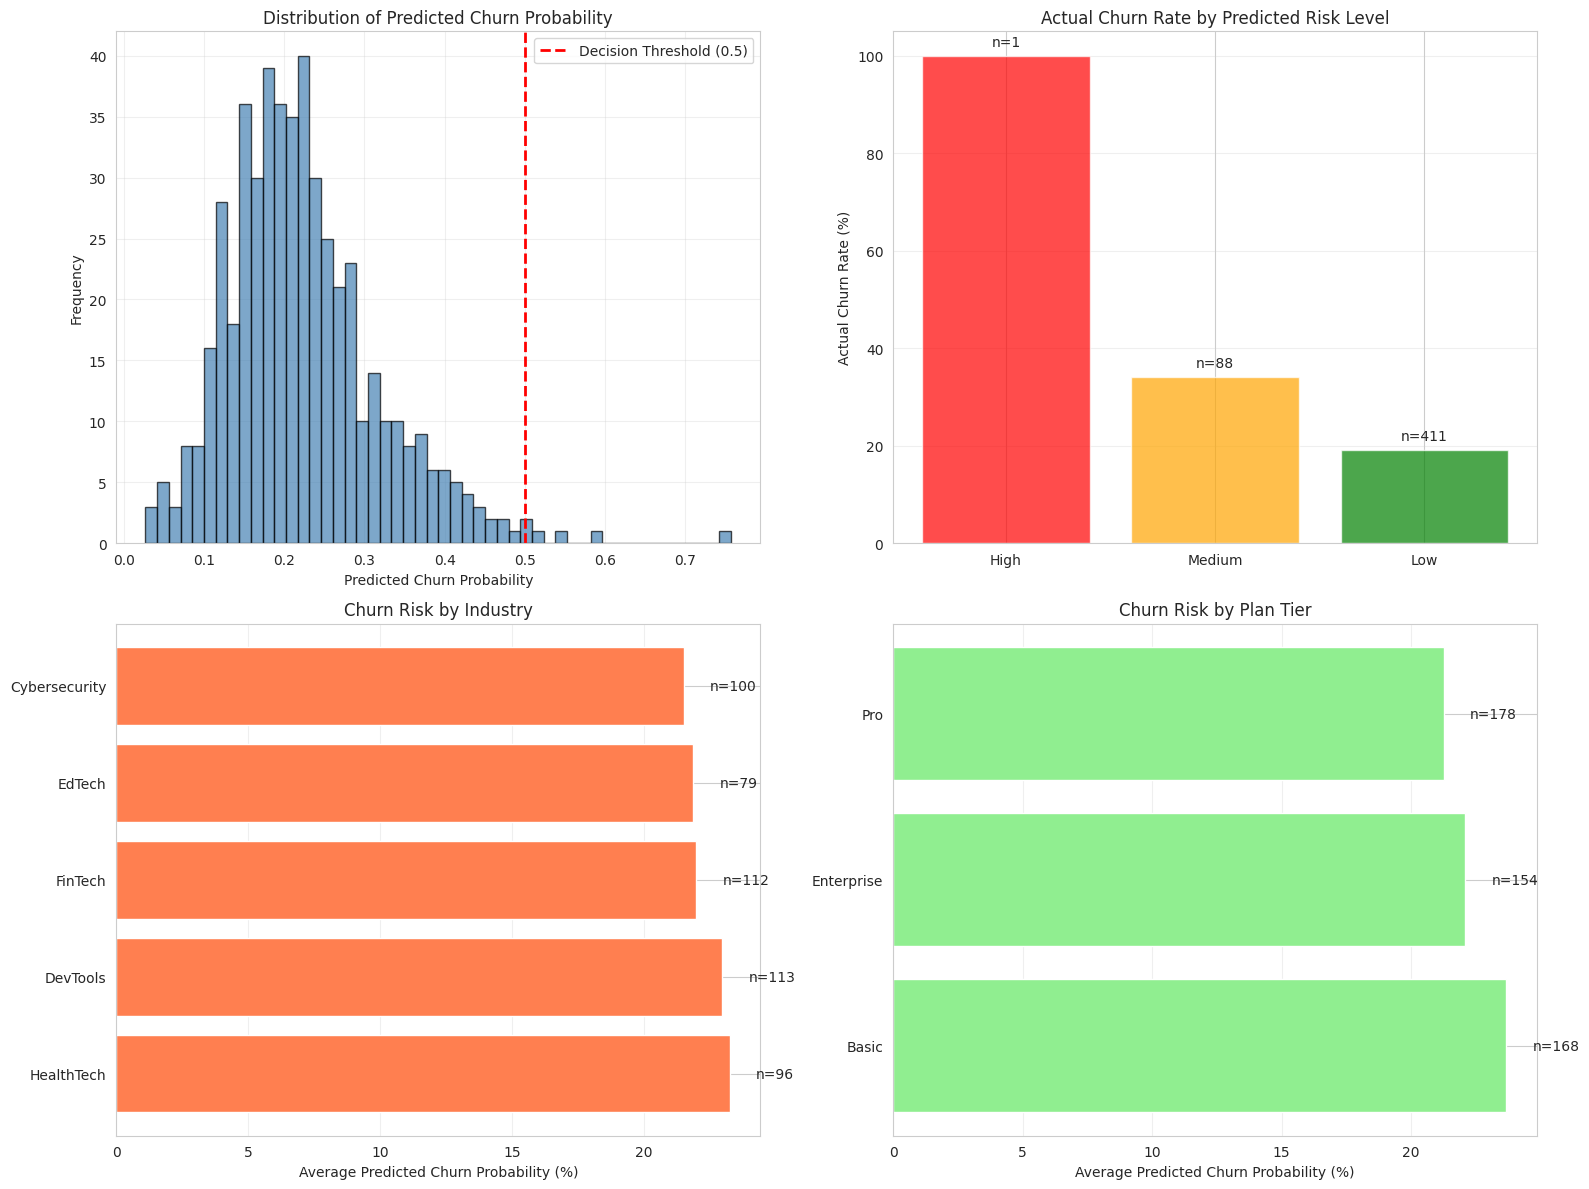

✓ Visualizations complete


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of predicted churn probability
axes[0, 0].hist(predictions_df['predicted_churn_probability'], bins=50,
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[0, 0].set_xlabel('Predicted Churn Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Predicted Churn Probability')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Actual vs Predicted churn by risk level
risk_actual = predictions_df.groupby('churn_risk_level')['actual_churn'].agg(['sum', 'count'])
risk_actual['actual_rate'] = risk_actual['sum'] / risk_actual['count']
risk_actual = risk_actual.reindex(['High', 'Medium', 'Low'])

x_pos = np.arange(len(risk_actual))
axes[0, 1].bar(x_pos, risk_actual['actual_rate'] * 100, color=['red', 'orange', 'green'], alpha=0.7)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(risk_actual.index)
axes[0, 1].set_ylabel('Actual Churn Rate (%)')
axes[0, 1].set_title('Actual Churn Rate by Predicted Risk Level')
axes[0, 1].grid(alpha=0.3, axis='y')

# Add count labels on bars
for i, (idx, row) in enumerate(risk_actual.iterrows()):
    axes[0, 1].text(i, row['actual_rate'] * 100 + 2, f"n={int(row['count'])}", ha='center')

# 3. Churn risk by industry
industry_churn = predictions_df.groupby('industry').agg({
    'predicted_churn_probability': 'mean',
    'account_id': 'count'
}).sort_values('predicted_churn_probability', ascending=False)
industry_churn.columns = ['avg_churn_prob', 'count']

axes[1, 0].barh(range(len(industry_churn)), industry_churn['avg_churn_prob'] * 100, color='coral')
axes[1, 0].set_yticks(range(len(industry_churn)))
axes[1, 0].set_yticklabels(industry_churn.index)
axes[1, 0].set_xlabel('Average Predicted Churn Probability (%)')
axes[1, 0].set_title('Churn Risk by Industry')
axes[1, 0].grid(alpha=0.3, axis='x')

# Add count labels
for i, (idx, row) in enumerate(industry_churn.iterrows()):
    axes[1, 0].text(row['avg_churn_prob'] * 100 + 1, i, f"n={int(row['count'])}", va='center')

# 4. Churn risk by plan tier
plan_churn = predictions_df.groupby('plan_tier').agg({
    'predicted_churn_probability': 'mean',
    'account_id': 'count'
}).sort_values('predicted_churn_probability', ascending=False)
plan_churn.columns = ['avg_churn_prob', 'count']

axes[1, 1].barh(range(len(plan_churn)), plan_churn['avg_churn_prob'] * 100, color='lightgreen')
axes[1, 1].set_yticks(range(len(plan_churn)))
axes[1, 1].set_yticklabels(plan_churn.index)
axes[1, 1].set_xlabel('Average Predicted Churn Probability (%)')
axes[1, 1].set_title('Churn Risk by Plan Tier')
axes[1, 1].grid(alpha=0.3, axis='x')

# Add count labels
for i, (idx, row) in enumerate(plan_churn.iterrows()):
    axes[1, 1].text(row['avg_churn_prob'] * 100 + 1, i, f"n={int(row['count'])}", va='center')

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")